<img src="figs/logocimat.png" height="20%" width="20%"  align="center"/>

<center> Estadística y computación para metagenómica<center>

<center> Víctor Muñiz Sánchez <center>

# Cross Validation y selección de modelos

Ilustraremos el procedimiento con el conjunto de datos Iris y una red neuronal con una sola capa oculta

In [5]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
plt.ioff() 

iris = load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


La manera estándar que hemos visto de evaluación de modelos es usando **un solo** fold, es decir, creando un conjunto de entrenamiento y otro de prueba

In [6]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
## Multilayer Perceptron
hls = [3,]
a = 0 # regularización
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=hls, random_state=0, max_iter=500, 
                    alpha=a).fit(X_train, y_train)

# predecir datos de prueba
y_test_hat = mlp.predict(X_test)
print("Test accuracy: {:.3f}".format(metrics.accuracy_score(y_test,y_test_hat)))

Test accuracy: 0.974


## K-Fold CV

Usamos CV de `scikit learn`. Esto nos permite, como vimos en clase, tener una mejor idea sobre la *generalización* del modelo. Por ejemplo, usando 3-fold CV:

In [7]:
hls = [3,]
a = 0 # regularización
mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=hls, random_state=0, max_iter=500, 
                    alpha=a)
scores = cross_val_score(mlp, iris.data, iris.target, cv=3)
print("Cross-validation scores: {}".format(scores))
print("Mean score: {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std() * 2))

Cross-validation scores: [1.   0.98 0.94]
Mean score: 0.97 (+/- 0.05)


Observa que, por default, `cross_val_score` calcula la precisión, pero puedes elegir otra métrica:

In [8]:
scores = cross_val_score(mlp, iris.data, iris.target, cv=3, scoring='f1_macro')
print("Cross-validation scores: {}".format(scores))
print("Mean score: {:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std() * 2))

Cross-validation scores: [1.         0.9797235  0.93998812]
Mean score: 0.97 (+/- 0.05)


Otro punto importante, es que, `cross_val_score` realiza CV Estratificado por default para casi todos los clasificadores de `scikit learn` (los que heredan de la clase `ClassifierMixIn` para calcular su score). La diferencia entre ambos es la que se muestra en las figuras. 

<img src="figs/cv.png" height="80%" width="80%"  align="center"/>


Otra forma de asegurar una correcta partición de nuestros datos, además de la estratificación, es aleatorizar (`shuffle`) los splits.

Compara los resultados con éstas 3 estrategias:

In [9]:
kfold = KFold(n_splits=3)
scores = cross_val_score(mlp, iris.data, iris.target, cv=kfold)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0. 0. 0.]


3-fold CV estándar aleatorizando

In [10]:
kfold = KFold(n_splits=3, shuffle=True)
scores = cross_val_score(mlp, iris.data, iris.target, cv=kfold)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96 0.98 0.94]


Ahora compáralo con 3-fold CV estratificado

In [11]:
kfold = StratifiedKFold(n_splits=3)
scores = cross_val_score(mlp, iris.data, iris.target, cv=kfold)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.   0.98 0.94]


## Leave-one-out CV

In [12]:
from sklearn.model_selection import LeaveOneOut
loo_cv = LeaveOneOut()
scores = cross_val_score(mlp, iris.data, iris.target, cv=loo_cv, n_jobs=-1)
print("Number of cv iterations: ", len(scores))
print("Mean score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Number of cv iterations:  150
Mean score: 0.97 (+/- 0.32)


El módulo `model_selection` tiene más utilidades... Checa la documentación si quieres profundizar.

## Grid search.

Siguiendo un esquema de CV, podemos elegir el *mejor* modelo mediante una búsqueda en un grid de parámetros. En este ejemplo, buscamos los parámetros del número de unidades ocultas y el parámetro de regularización (weight decay)

In [41]:
import numpy as np

best_score = 0
scores_mean = []
scores_sd = []
for hidden in [1,2,3,4,5]:
    for alpha in [0.01, 0.1, 1, 5, 10]:
        # for each combination of parameters,
        # train an MLP
        mlp = MLPClassifier(solver='sgd', hidden_layer_sizes=[hidden,], random_state=0, 
                            max_iter=5000, alpha=alpha)
        # perform cross-validation
        scores = cross_val_score(mlp, X_train, y_train, cv=3)
        scores_mean.append(scores.mean())
        scores_sd.append(scores.std() * 2)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'hidden_layer_sizes': hidden, 'alpha': alpha}


In [42]:
print('best parameters:', best_parameters)
print('best score:', best_score)

best parameters: {'hidden_layer_sizes': 4, 'alpha': 0.01}
best score: 0.981981981981982


In [15]:
# rebuild a model on the combined training and validation set
mlp = MLPClassifier(**best_parameters, max_iter=5000)
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=4, max_iter=5000)

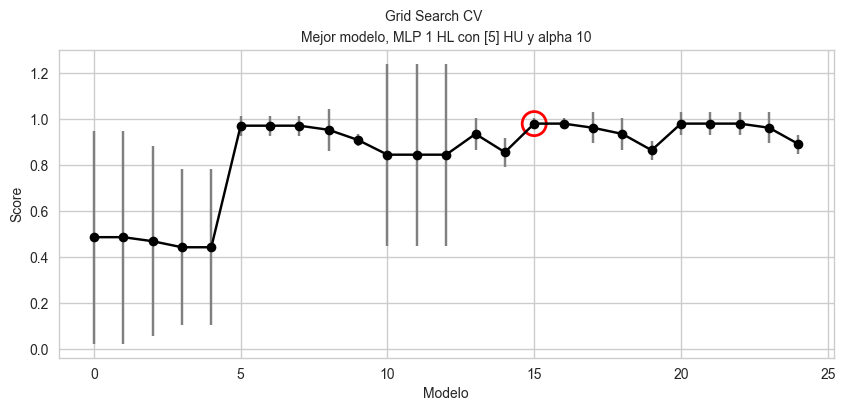

In [49]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)
plt.errorbar(list(range(0,len(scores_mean))), scores_mean, yerr=scores_sd, fmt='-o', color='black',
             ecolor='gray')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean)],
                   s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.xlabel('Modelo',size=10)
plt.ylabel('Score',size=10)
plt.suptitle('Grid Search CV',size=10)
txt = 'Mejor modelo, MLP 1 HL con ' + str(mlp.hidden_layer_sizes) + ' HU y alpha ' + str(mlp.alpha)
plt.title(txt,size=10)
plt.show()

Podemos hacer lo mismo para una SVM con un kernel Gaussiano. En este caso, buscamos el ancho del kernel $\sigma$ y la regularización óptimos.

In [18]:
from sklearn.svm import SVC

best_score = 0
scores_mean = []
scores_sd = []
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVM
        svm = SVC(kernel = 'rbf', gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_train, y_train, cv=5)
        scores_mean.append(scores.mean())
        scores_sd.append(scores.std() * 2)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:            
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

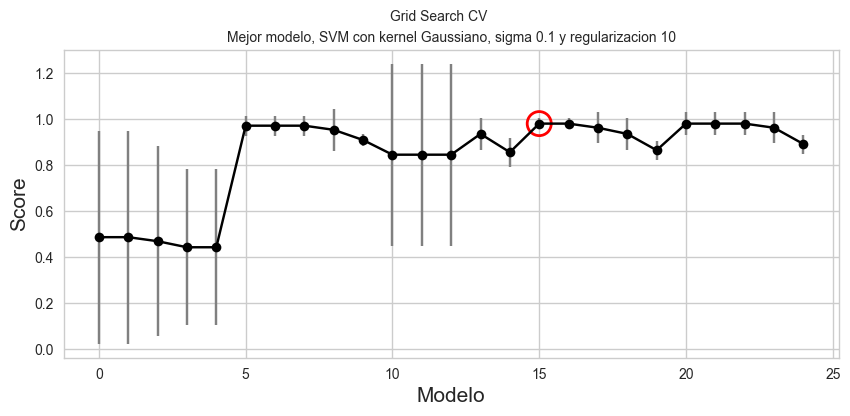

In [50]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.errorbar(list(range(0,len(scores_mean))), scores_mean, yerr=scores_sd, fmt='-o', color='black',
             ecolor='gray',)
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean)],
                   s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.xlabel('Modelo',size=15)
plt.ylabel('Score',size=15)
plt.suptitle('Grid Search CV',size=10)
txt = 'Mejor modelo, SVM con kernel Gaussiano, sigma ' + str(svm.gamma) + ' y regularizacion ' + str(svm.C)
plt.title(txt,size=10)
plt.show()

`scikit learn` tiene un método eficiente para Grid Search en el módulo `model_selection`. En este ejemplo, buscamos el modelo óptimo entre un SVM con kernel lineal y uno con kernel Gaussiano, así como sus respectivos parámetros

In [55]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
# El grid de parámetros lo definimos como un diccionario

parameters = [{'solver': ['sgd'], 'max_iter': [5000], 
               'hidden_layer_sizes': [1,2,3,4,5], 'alpha': [0.01, 0.1, 1, 5, 10]}]

# Realiza Grid Search
cvfolds = 5
GS = GridSearchCV(estimator=MLPClassifier(), param_grid=parameters, cv = cvfolds, 
                  return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid=[{'alpha': [0.01, 0.1, 1, 5, 10],
                          'hidden_layer_sizes': [1, 2, 3, 4, 5],
                          'max_iter': [5000], 'solver': ['sgd']}],
             return_train_score=True)

In [56]:
print('best estimator:', GS.best_estimator_)
print('best score:', GS.best_score_)

best estimator: MLPClassifier(alpha=5, hidden_layer_sizes=5, max_iter=5000, solver='sgd')
best score: 0.9458498023715414


En el gráfico se muestran los scores para los datos de entrenamiento y prueba del proceso de CV en el grid search

In [57]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

En color azul ténue se muestra un IC alrededor del score promedio de $\pm 2\sigma$

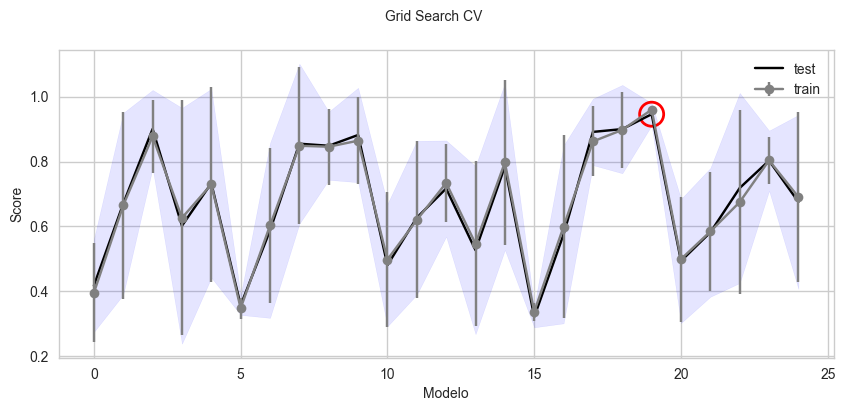

In [60]:
plt.style.use("seaborn-v0_8-whitegrid")
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (10, 4)
plt.fill_between(x_ax, scores_mean-scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=10)
plt.ylabel('Score',size=10)
plt.suptitle('Grid Search CV',size=10)
plt.legend(loc="best")
plt.show()

In [62]:
from sklearn.model_selection import GridSearchCV
# El grid de parámetros lo definimos como un diccionario
parameters = [
  {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
]
# Realiza Grid Search
cvfolds = 5
GS = GridSearchCV(estimator=SVC(), param_grid=parameters, cv = cvfolds, return_train_score=True, n_jobs=-1)
GS.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['linear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']}],
             return_train_score=True)

Resultados

In [63]:
GS.best_estimator_

SVC(C=1, kernel='linear')

In [64]:
print('Best score:', GS.best_score_) 
print('Best C:',GS.best_estimator_.C) 
print('Best Kernel:',GS.best_estimator_.kernel)
print('Best Gamma:',GS.best_estimator_.gamma)

Best score: 0.9731225296442687
Best C: 1
Best Kernel: linear
Best Gamma: scale


En el gráfico se muestran los scores para los datos de entrenamiento y prueba del proceso de CV en el grid search

In [65]:
scores_mean = GS.cv_results_['mean_test_score']
scores_sd = GS.cv_results_['std_test_score']
scores_mean_tr = GS.cv_results_['mean_train_score']
scores_sd_tr = GS.cv_results_['std_train_score']

En color azul ténue se muestra un IC alrededor del score promedio de $\pm 2\sigma$

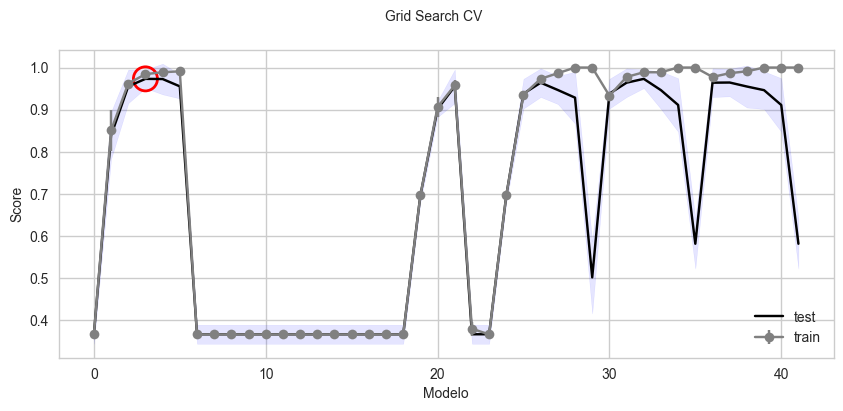

In [66]:
plt.style.use('seaborn-v0_8-whitegrid')
x_ax = list(range(0,len(scores_mean)))
plt.rcParams['figure.figsize'] = (10, 4)
plt.fill_between(x_ax, scores_mean - scores_sd, scores_mean + scores_sd, alpha=0.1, color='blue')
plt.plot(x_ax, scores_mean, color='black',label='test')
plt.scatter(np.argmax(scores_mean), scores_mean[np.argmax(scores_mean),], s=300, linewidth=2, facecolors = 'none', edgecolors='red')
plt.errorbar(x_ax, scores_mean_tr, yerr=scores_sd_tr, fmt='-o', color='gray', ecolor='gray',label='train')
plt.xlabel('Modelo',size=10)
plt.ylabel('Score',size=10)
plt.suptitle('Grid Search CV',size=10)
plt.legend(loc="best")
plt.show()

También se muestran los resultados individuales para cada modelo, donde puedes identificar el mejor. Observa que hay dos modelos igual de buenos (el 3 y el 32), con score de  0.973 (+/-0.044), sin embargo, se escoje el primero porque es más simple (kernel lineal)

In [67]:
print("Grid scores:")
print()
means = GS.cv_results_['mean_test_score']
stds = GS.cv_results_['std_test_score']
i=0
for mean, std, params in zip(means, stds, GS.cv_results_['params']):
    print("Model: {}. {:.3f} (+/-{:.03f}) for {}".format(i,mean, std*2,params))
    i+= 1


Grid scores:

Model: 0. 0.366 (+/-0.045) for {'C': 0.001, 'kernel': 'linear'}
Model: 1. 0.839 (+/-0.112) for {'C': 0.01, 'kernel': 'linear'}
Model: 2. 0.955 (+/-0.080) for {'C': 0.1, 'kernel': 'linear'}
Model: 3. 0.973 (+/-0.044) for {'C': 1, 'kernel': 'linear'}
Model: 4. 0.973 (+/-0.073) for {'C': 10, 'kernel': 'linear'}
Model: 5. 0.955 (+/-0.058) for {'C': 100, 'kernel': 'linear'}
Model: 6. 0.366 (+/-0.045) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
Model: 7. 0.366 (+/-0.045) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
Model: 8. 0.366 (+/-0.045) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
Model: 9. 0.366 (+/-0.045) for {'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}
Model: 10. 0.366 (+/-0.045) for {'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}
Model: 11. 0.366 (+/-0.045) for {'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}
Model: 12. 0.366 (+/-0.045) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Model: 13. 0.366 (+/-0.045) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Model: 14

In [68]:
from sklearn.metrics import classification_report
print("Detailed classification report:")
print()
print("El modelo se escogió haciendo CV en el conjunto de entrenamiento.")
print("Estos resultados corresponden a la evaluación en el conjunto de prueba.")
print()
y_true, y_pred = y_test, GS.predict(X_test)
print(classification_report(y_true, y_pred))
print()

Detailed classification report:

El modelo se escogió haciendo CV en el conjunto de entrenamiento.
Estos resultados corresponden a la evaluación en el conjunto de prueba.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38


